$-A_1 \exp\left(-\left(\frac{x - cx_1}{kx_1}\right)^2 - \left(\frac{y - cy_1}{ky_1}\right)^2 - \left(\frac{z - cz_1}{kz_1}\right)^2\right) - A_2 \exp\left(-\left(\frac{x - cx_2}{kx_2}\right)^2 - \left(\frac{y - cy_2}{ky_2}\right)^2 - \left(\frac{z - cz_2}{kz_2}\right)^2\right) - A_3 \exp\left(-\left(\frac{x - cx_3}{kx_3}\right)^2 - \left(\frac{y - cy_3}{ky_3}\right)^2 - \left(\frac{z - cz_3}{kz_3}\right)^2\right)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import numpy as np 
import scipy.sparse as sp
import scipy.sparse.linalg as linalg
import h5py
import os
from icecream import ic

# import pytorch3d
# from solver_ import Solver

In [2]:
# rc param tex use true
plt.rcParams['text.usetex'] = True

In [3]:
class Solver:
  def __init__(self, L, limit, N, mode='sho'):
    self.L = L
    self.limit = limit
    self.N = N
    self.mode = mode

  def getMesh(self):
    """
    return:
      mesh: meshgrid of x, y, z
      h: step size
    """
    x = np.linspace(-self.limit, self.limit, self.L)
    h = x[1]-x[0]
    mesh = np.meshgrid(x, x, x)
    return mesh, h
  
  def getRandom(self):
    """
    return:
      param: random parameters
    """
    if self.mode == 'sho':
      kx = np.random.rand(self.N) * 0.36
      ky = np.random.rand(self.N) * 0.36
      kz = np.random.rand(self.N) * 0.36
      cx = -8 + (np.random.rand(self.N)) * 8
      cy = -8 + (np.random.rand(self.N)) * 8
      cz = -8 + (np.random.rand(self.N)) * 8

      return kx, ky, kz, cx, cy, cz

    elif self.mode == 'dwig':
      A1 = 2 + np.random.random(self.N)*2
      A2 = 2 + np.random.random(self.N)*2
      A3 = 2 + np.random.random(self.N)*2
      cx1 = -8 + np.random.random(self.N)*16
      cx2 = -8 + np.random.random(self.N)*16
      cx3 = -8 + np.random.random(self.N)*16
      cy1 = -8 + np.random.random(self.N)*16
      cy2 = -8 + np.random.random(self.N)*16
      cy3 = -8 + np.random.random(self.N)*16
      cz1 = -8 + np.random.random(self.N)*16
      cz2 = -8 + np.random.random(self.N)*16
      cz3 = -8 + np.random.random(self.N)*16
      kx1 = 1.6 + np.random.random(self.N)*6.4
      kx2 = 1.6 + np.random.random(self.N)*6.4
      kx3 = 1.6 + np.random.random(self.N)*6.4
      ky1 = 1.6 + np.random.random(self.N)*6.4
      ky2 = 1.6 + np.random.random(self.N)*6.4
      ky3 = 1.6 + np.random.random(self.N)*6.4
      kz1 = 1.6 + np.random.random(self.N)*6.4
      kz2 = 1.6 + np.random.random(self.N)*6.4
      kz3 = 1.6 + np.random.random(self.N)*6.4

      return A1, A2, A3, cx1, cy1, cz1, cx2, cy2, cz2, cx3, cy3, cz3, kx1, ky1, kz1, kx2, ky2, kz2, kx3, ky3, kz3
    
    elif self.mode == 'iw':
      # ic("here")
      E = 0.1 + np.random.random(int(self.N/3))*0.8
      term1 = np.pi**2 / (2 * E)
      Lxs = []
      Lys = []
      Lzs = []
      cxs = []
      cys = []
      czs = []
      for term in term1:
        cx = -8 + (np.random.rand() * 16)
        cy = -8 + (np.random.rand() * 16)
        cz = -8 + (np.random.rand() * 16)
        Ly = Lz = np.inf
        while (Ly**2 + Lz**2) > term:
          Ly, Lz = self.RandomL()
        Lx = np.sqrt(term - Ly**2 - Lz**2)
        Lxs.append(Lx)
        Lys.append(Ly)
        Lzs.append(Lz)
        cxs.append(cx)
        cys.append(cy)
        czs.append(cz)

      E = np.repeat(E, 3)
      Lxs_ = np.array(Lxs + Lys + Lzs)
      Lys_ = np.array(Lys + Lzs + Lxs)
      Lzs_ = np.array(Lzs + Lxs + Lys)
      cx_ = np.array(cxs + cys + czs)
      cy_ = np.array(cys + czs + cxs)
      cz_ = np.array(czs + cxs + cys)

      if self.N%3!=0:
        iw_len = int(self.N/3)*3
        range_ = self.N - iw_len
        idx = np.random.randint(0, iw_len, range_)
        E = np.concatenate((E, E[idx]))
        Lxs_ = np.concatenate((Lxs_, Lxs_[idx]))
        Lys_ = np.concatenate((Lys_, Lys_[idx]))
        Lzs_ = np.concatenate((Lzs_, Lzs_[idx]))
        cx_ = np.concatenate((cx_, cx_[idx]))
        cy_ = np.concatenate((cy_, cy_[idx]))
        cz_ = np.concatenate((cz_, cz_[idx]))

      # delete unreturned variable
      del Lxs, Lys, Lzs
      del Ly, Lz, Lx, term1
      del cxs, cys, czs
      # ic(len(E), len(Lxs_), len(Lys_), len(Lzs_), len(cx_), len(cy_), len(cz_))
      return E, Lxs_, Lys_, Lzs_, cx_, cy_, cz_
    
  def T(self, h):
    diag = np.ones([self.L])
    diags = np.array([diag, -2*diag, diag])
    D = sp.spdiags(diags, np.array([-1, 0, 1]), self.L, self.L)/h**2
    D1 = sp.kronsum(D,D)
    D1 = sp.kronsum(D1,D)
    return -0.5 * D1
      
  def V_sho(self, mesh, param):
    kx, ky, kz, cx, cy, cz = param
    (x,y,z) = mesh
    potential = 0.5 * (kx*(x-cx)**2 + ky*(y-cy)**2 + kz*(z-cz)**2)
    V = sp.diags(potential.reshape(self.L**3),(0), )
    return V, potential

  def V_dwig(self, mesh, param):
    A1, A2, A3, cx1, cy1, cz1, cx2, cy2, cz2, cx3, cy3, cz3, kx1, ky1, kz1, kx2, ky2, kz2, kx3, ky3, kz3 = param
    (x,y,z) = mesh
    potential = \
      - A1 * np.exp(-((x - cx1) / kx1)**2 - ((y - cy1) / ky1)**2 - ((z - cz1) / kz1)**2) \
      - A2 * np.exp(-((x - cx2) / kx2)**2 - ((y - cy2) / ky2)**2 - ((z - cz2) / kz2)**2) \
      - A3 * np.exp(-((x - cx3) / kx3)**2 - ((y - cy3) / ky3)**2 - ((z - cz3) / kz3)**2)
    V = sp.diags(potential.reshape(self.L**3),(0), )
    return V, potential
  
  def RandomL(self):
    Ly = 1 + np.random.rand() * 10
    Lz = 1 + np.random.rand() * 10
    return Ly, Lz

  def V_iw(self, mesh, param):
    (x,y,z) = mesh
    E, Lx, Ly, Lz, cx, cy, cz = param
    upperX = 0.5*(2*cx + Lx)
    lowerX = 0.5*(2*cx - Lx)
    upperY = 0.5*(2*cy + Ly)
    lowerY = 0.5*(2*cy - Ly)
    upperZ = 0.5*(2*cz + Lz)
    lowerZ = 0.5*(2*cz - Lz)

    potential = np.zeros((self.L, self.L, self.L))
    for i in range(self.L):
      for j in range(self.L):
        for k in range(self.L):
          if (lowerX < x[i,j,k] <= upperX) and (lowerY < y[i,j,k] <= upperY) and (lowerZ < z[i,j,k] <= upperZ):
            potential[i,j,k] = 0
          else:
            potential[i,j,k] = 20
    
    V = sp.diags(potential.reshape(self.L**3),(0), )
    
    return V, potential, E

  def solve(self):
    """
    return:
      energies: energies of the images
      imgs: images
    """
    mesh, h = self.getMesh()
    T = self.T(h)
    (param) = self.getRandom()
    param = np.array(param).T
    energies = np.zeros((self.N, 1))
    imgs = np.zeros((self.N, self.L, self.L, self.L))

    for idx in range(self.N):
      if self.mode=='iw':
        # print(idx, end='\r', flush=True)
        V, img, E = self.V_iw(mesh, param[idx])
        energies[idx] = E
        imgs[idx] = img
        
      else:
        V, img = self.V_sho(mesh, param[idx]) if self.mode == 'sho' else self.V_dwig(mesh, param[idx])
        H = T + V
        E = linalg.eigsh(H, k=1, which='SA', return_eigenvectors=False)
        energies[idx] = np.real(E)
        imgs[idx] = img

    return energies, imgs
  
  def create_train_data(self, filename, num_augmentations=0.2):
    """
    param:
      filename: name of the file to save the data 
      num_augmentations: number of augmentations per image. Default is range between 0 and 1. If int is given, it is the number of augmentations per image.
    return:
      energies: energies of the images
      imgs: images
    """
    energies, imgs = self.solve()
    # generate random indeks sebanyak num_augmentations
    if num_augmentations < 1:
      num_augmentations = int(self.N*num_augmentations)
    idx = np.random.randint(0, self.N, int(num_augmentations))
    addition_data = np.zeros((num_augmentations, self.L, self.L, self.L))
    rotations = [90, 180, 270]
    idx_ax = [0, 1, 2]
    axes = [(0,1), (1,2), (0,2)]

    for index, i in enumerate(idx):
      # rotate
      rot = np.random.choice(rotations)
      idx_axis = np.random.choice(idx_ax)
      addition_data[index] = rotate(imgs[i], angle=rot, axes=axes[idx_axis], reshape=False)

    energies = np.concatenate((energies, energies[idx]))
    imgs = np.concatenate((imgs, addition_data))

    # del unused variable
    del addition_data, rotations, axes, idx

    with h5py.File(filename, 'w') as hf:
      hf.create_dataset('feature', data=imgs)
      hf.create_dataset('target', data=energies)
    return energies, imgs
  
  def create_test_data(self, filename, num_data):
    """
    param:
      filename: name of the file to save the data 
      num_data: number of data to be generated
    return:
      energies: energies of the images
      imgs: images
    """
    if num_data<1:
      self.N = int(self.N*num_data)

    energies, imgs = self.solve()
    with h5py.File(filename, 'w') as hf:
      hf.create_dataset('feature', data=imgs)
      hf.create_dataset('target', data=energies)
    return energies, imgs
  
def random_split(X, y, val_split=0.2):
  N = X.shape[0]
  # idx = np.random.permutation(N)
  # train_idx = idx[:int(train_split*N)]
  # val_idx = idx[int(train_split*N):int((train_split+val_split)*N)]
  idx = np.random.randint(0, N, int(val_split*N))
  val_idx = idx
  train_idx = np.delete(np.arange(N), idx)
  return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

In [4]:
L = 64
limit = 20
N = 1
mode = 'sho'

S = Solver(L, limit, N, mode)
energies, imgs = S.create_train_data('te.h5')

In [5]:
L = 64
limit = 20
N = 4
mode = 'iw'

S = Solver(L, limit, N, mode)
energies1, imgs1 = S.create_train_data('te.h5')

In [6]:
L = 64
limit = 20
N = 4
mode = 'dwig'

S = Solver(L, limit, N, mode)
energies2, imgs2 = S.create_train_data('te.h5')

In [13]:
x = np.linspace(-limit, limit, L)
X, Y, Z = np.meshgrid(x, x, x)

def plot(imgs, filename,  mode='normal'):
  # plot
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlim(-limit, limit)
  ax.set_ylim(-limit, limit)
  ax.set_zlim(-limit, limit)
  # ax.set_xlabel('X')
  # ax.set_ylabel('Y')
  # ax.set_zlabel('Z')

  alphas = []
  index = []
  if mode=='sho':
    alphas = np.ones_like(imgs.flatten())*0.25
  else:
    for idx, i in enumerate(imgs.flatten()):
      if mode=='iw':
        if i == 20:
          alphas.append(0.01)
          index.append(idx)
        else:
          alphas.append(1)
      elif mode=='dwig':
        if i <= -1.0:
          alphas.append(1)
          index.append(idx)
        elif i > -1.0:
          alphas.append(0.01)

  im = ax.scatter(X, Y, Z, c=imgs, cmap='viridis', alpha=alphas, s=3, rasterized=True)
  # disable tick
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])
  # add colorbar
  # cbar = fig.colorbar(im, ax=ax, shrink=0.5)
  # cbar.solids.set(alpha=1)
  plt.savefig(filename, transparent=True, bbox_inches='tight', pad_inches=0)
  plt.show()

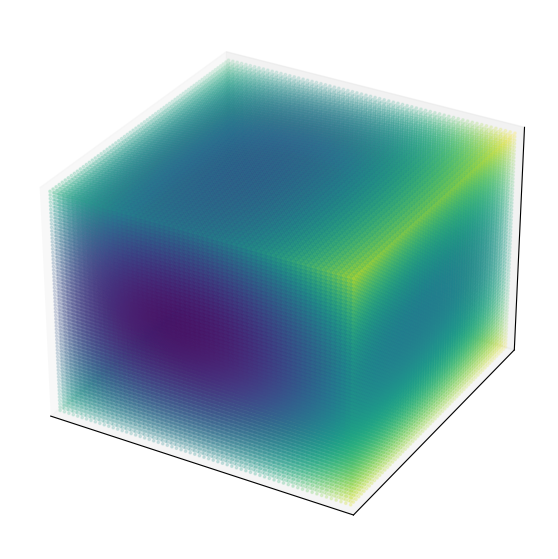

In [14]:
plot(imgs[0], mode='sho', filename='../fig/sho.svg')

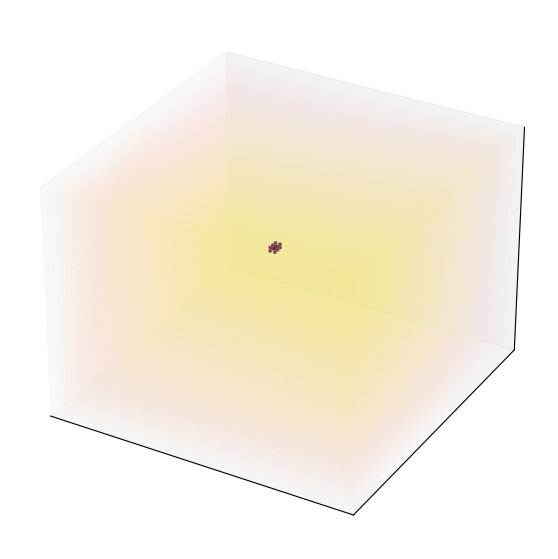

In [15]:
plot(imgs1[2], mode='iw', filename='../fig/iw.svg')

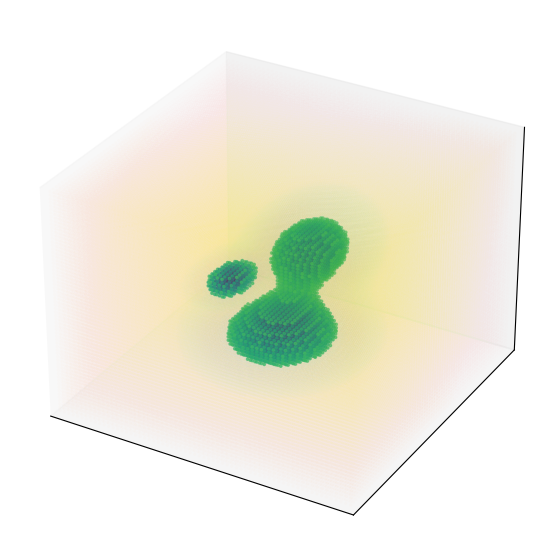

In [16]:
plot(imgs2[2], mode='dwig', filename='../fig/dwig.svg')

In [17]:
# rotated_tensor = rotate_3d_tensor(imgs[0], 90, 'x')
# plot(rotated_tensor)
angle = 90
rotated_tensor1 = rotate(imgs2[0], angle=angle, axes=(0, 1), reshape=False) # rotate along x axis
rotated_tensor2 = rotate(imgs2[0], angle=angle, axes=(1, 2), reshape=False) # rotate along y axis
rotated_tensor3 = rotate(imgs2[0], angle=angle, axes=(0, 2), reshape=False) # rotate along z axis

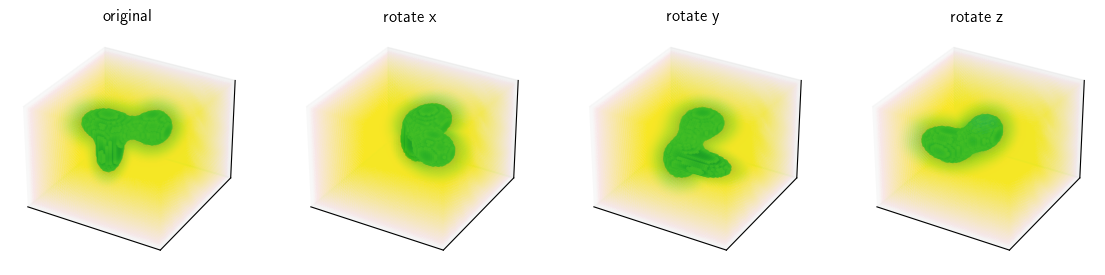

In [18]:
ploted = [imgs2[0], rotated_tensor1, rotated_tensor2, rotated_tensor3]
name = ['original', 'rotate x', 'rotate y', 'rotate z']
fig, axes = plt.subplots(1, 4, figsize=(14, 13), subplot_kw={'projection': '3d'})

for idx, ax in enumerate(axes.flatten()):
  ax.set_xlim(-limit, limit)
  ax.set_ylim(-limit, limit)
  ax.set_zlim(-limit, limit)
  # ax.set_xlabel('$X$')
  # ax.set_ylabel('$Y$')
  # ax.set_zlabel('$Z$')
  ax.set_title(name[idx])
  # ax.set_title(f'angle={90*idx} degree')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_zticks([])
  alphas = []
  for i in ploted[idx].flatten():
    # print(i, end=' '
    if i <= -1.0:
      alphas.append(1)
    elif i > -1.0:
      alphas.append(0.005)
  ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=ploted[idx].flatten(), cmap='viridis', alpha=alphas, s=3, rasterized=True)

plt.savefig('../fig/dwig_rotated.svg', transparent=True)